Original size: (512, 512, 3)


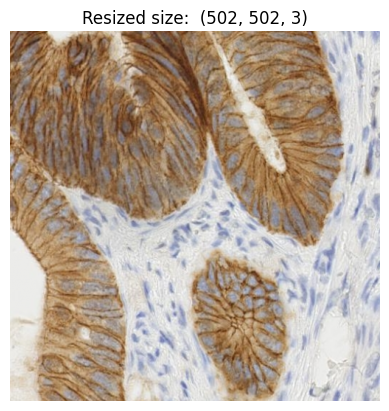

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.transform import resize

# Example IHC image
sample_image = data.immunohistochemistry()
print("Original size:", sample_image.shape)


# Resize image to 502x502
desired_size = (502, 502,3)
resized_image = resize(sample_image, desired_size, mode='reflect', anti_aliasing=True)
plt.title(f'Resized size:  {resized_image.shape}')
plt.imshow(resized_image)
plt.axis('off')
plt.show()

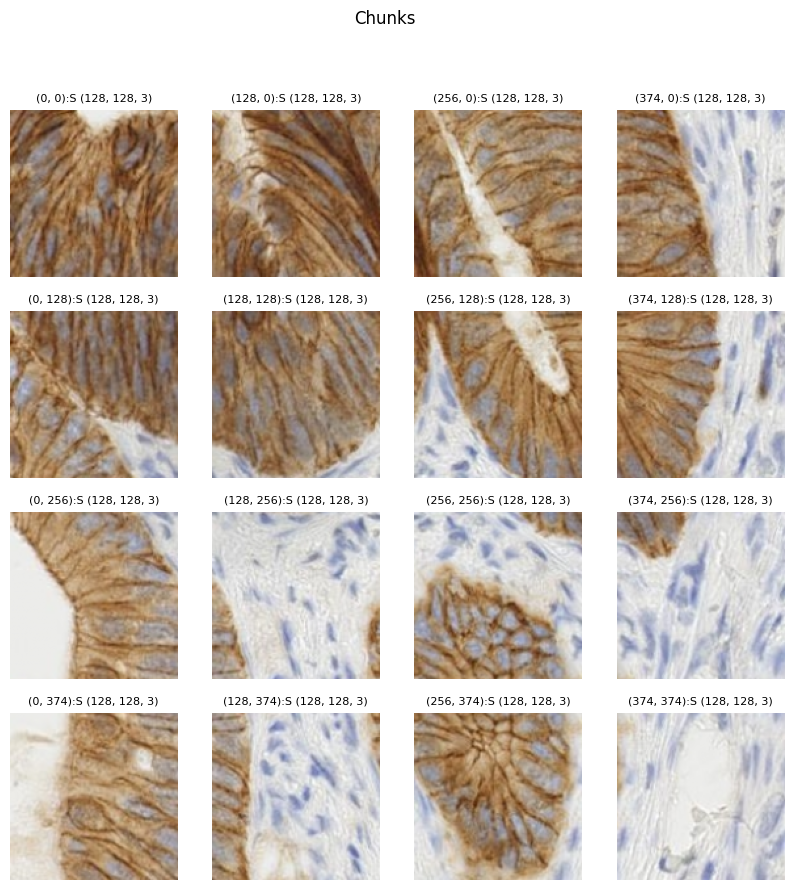

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import math



def chunk_image(image, chunk_size):

    chunks = []
    chunk_coords = []
    image_height, image_width = image.shape[:2]

    # Iterate over the image with steps of chunk_size
    for y in range(0, image_height, chunk_size):
        for x in range(0, image_width, chunk_size):
            #print(y , x)
            # Calculate end coordinates
            y_end = min(y + chunk_size, image_height)
            x_end = min(x + chunk_size, image_width)
            #print(y_end, x_end)
            if y== 384:
              y = 502-128
            if x == 384:
              x = 502-128


            # Extract chunk
            chunk = image[y:y_end, x:x_end]
            #print(chunk.shape)
            chunks.append(chunk)
            chunk_coords.append((x, y))

    return chunks, chunk_coords

resized_image = resized_image

chunk_size = 128
chunks, chunk_coords = chunk_image(resized_image, chunk_size)

# Visualize the chunks in a grid layout
num_chunks = len(chunks)
ncols = int(np.ceil(np.sqrt(num_chunks)))
nrows = int(np.ceil(num_chunks / ncols))

plt.figure(figsize=(10, 10))
plt.suptitle('Chunks')
for i, (chunk, (x_start, y_start)) in enumerate(zip(chunks, chunk_coords)):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(chunk)
    plt.title(f"({x_start}, {y_start}):S {chunk.shape}", fontsize=8)
    plt.axis('off')
    # plt.tight_layout()
plt.show()


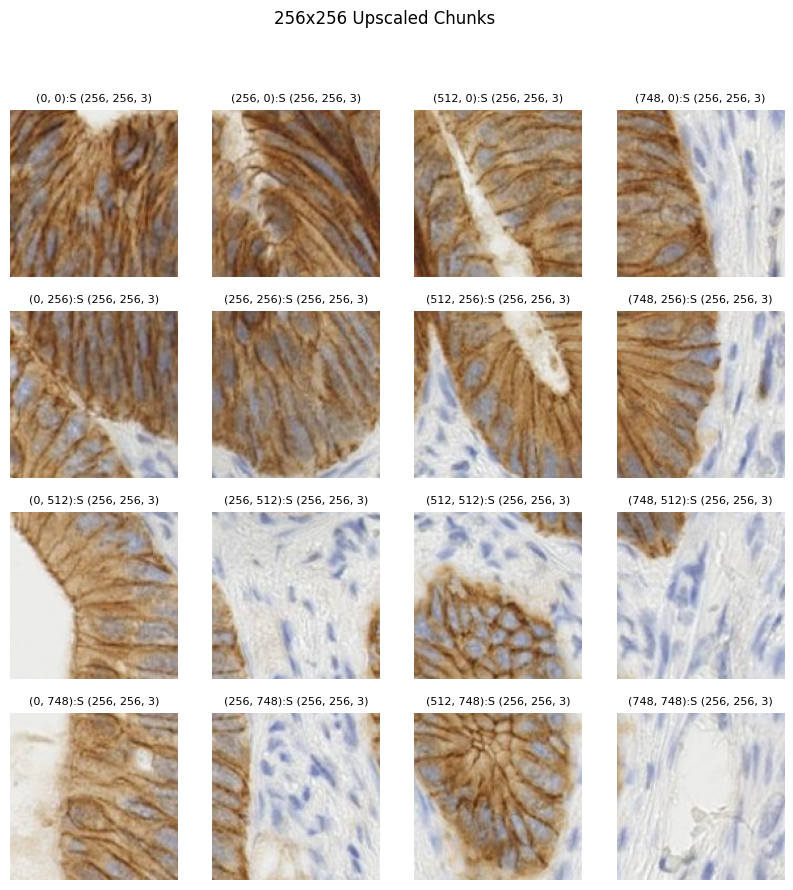

In [9]:
def upscale_chunks(chunks, chunk_coords, upscale_factor=2):


    upscaled_chunks = []
    upscaled_chunk_coords = []
    # will be feed into prediction from SR
    for i, chunk in enumerate(chunks):
        upscaled_chunk = np.zeros((chunk.shape[0] * upscale_factor, chunk.shape[1] * upscale_factor, chunk.shape[2]))
        for c in range(chunk.shape[2]):
            upscaled_chunk[..., c] = np.kron(chunk[..., c], np.ones((upscale_factor, upscale_factor)))
        upscaled_chunks.append(upscaled_chunk)

        x_start, y_start = chunk_coords[i]
        upscaled_chunk_coords.append((x_start * upscale_factor, y_start * upscale_factor))

    return upscaled_chunks, upscaled_chunk_coords



# Step 4: Upscale each chunk
upscaled_chunks, upscaled_chunk_coords = upscale_chunks(chunks, chunk_coords)

# Visualize the upscaled chunks in a grid layout
num_upscaled_chunks = len(upscaled_chunks)
ncols_upscaled = int(np.ceil(np.sqrt(num_upscaled_chunks)))
nrows_upscaled = int(np.ceil(num_upscaled_chunks / ncols_upscaled))

plt.figure(figsize=(10, 10))
plt.suptitle('256x256 Upscaled Chunks')
for i, (upscaled_chunk, (x_start, y_start)) in enumerate(zip(upscaled_chunks, upscaled_chunk_coords)):
    plt.subplot(nrows_upscaled, ncols_upscaled, i + 1)
    plt.imshow(upscaled_chunk)
    plt.title(f'({x_start}, {y_start}):S {upscaled_chunk.shape}', fontsize=8)  # Display coordinates as title
    plt.axis('off')
    # plt.tight_layout()
plt.show()

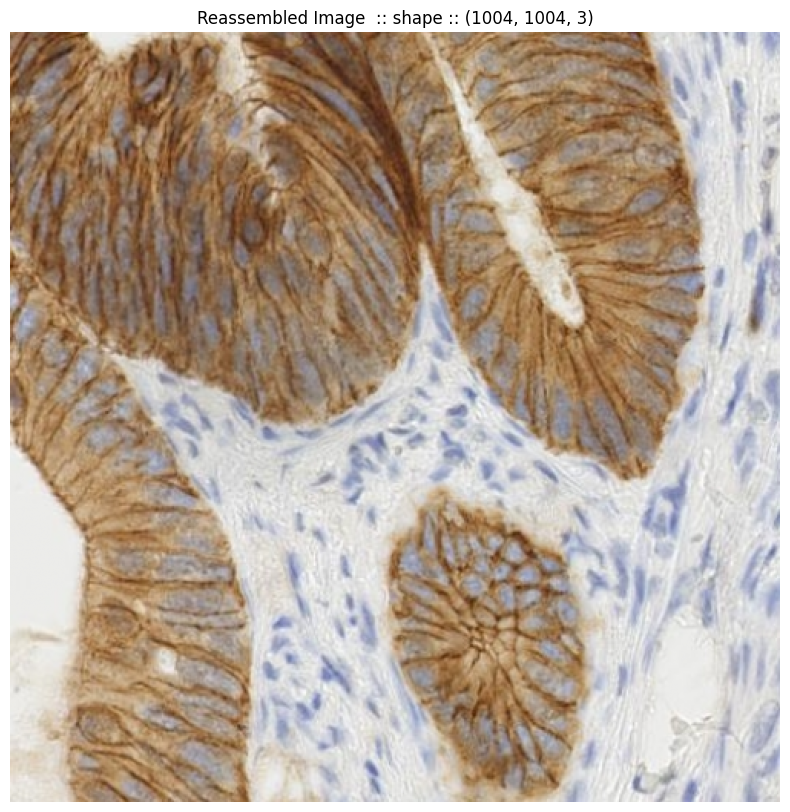

In [4]:


# Step 5: Reassemble the upscaled chunks into a 1004x1004 grid
target_size = 1004
final_image = np.zeros((target_size, target_size, resized_image.shape[2]))

for i, (upscaled_chunk, (x_start, y_start)) in enumerate(zip(upscaled_chunks, upscaled_chunk_coords)):
    x_end = min(x_start + upscaled_chunk.shape[1], target_size)
    y_end = min(y_start + upscaled_chunk.shape[0], target_size)

    # Ensure that x_end and y_end are valid indices
    if x_end > x_start and y_end > y_start:
        # Update the final image with the upscaled chunk, taking maximum values for overlaps
        final_image[y_start:y_end, x_start:x_end] = np.maximum(
            final_image[y_start:y_end, x_start:x_end],
            upscaled_chunk[:y_end-y_start, :x_end-x_start]
        )

# Visualize the final image
plt.figure(figsize=(10, 10))
plt.title(f'Reassembled Image  :: shape :: {final_image.shape}')
plt.imshow(final_image)

plt.axis('off')
plt.show()